## Random Forest models on the EFs
Run Random Forest on all EFs and establish feature importance. The results will then be used in the deep learning models.

This model is adapted from the Basic_models.ipynb and includes functions that are copied.


# Imports

In [1]:
# %%capture
# !pip install geopandas
# !pip install pandas --upgrade

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import xgboost
import os

# from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import shapely

In [3]:
from typing import List, Union
from pathlib import Path
from functools import reduce
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             average_precision_score, precision_recall_curve, auc, PrecisionRecallDisplay)
# TODO: amalgamate these
from sklearn import metrics


# Function definitions

In [18]:
def check_files_in_list_exist(
    file_list: Union[List[str], List[Path]]
    ):
    """State which files don't exist and remove from list"""
    files_found = []
    for fl in file_list:
        # attempt conversion to Path object if necessary
        if type(fl) != Path:
            try:
                fl = Path(fl)
            except TypeError:
                print(f'{fl} could not be converted to Path object')
        
        if fl.is_file():
            files_found += fl,
        else:
            print(f'{fl} not found. Removing from list.')

    return files_found


def read_and_merge_pkls(
    pkl_paths: Union[List[str], List[Path]]
) -> pd.DataFrame:
    """Read in pkl files from list of file paths and merge on index"""
    # check all files exist
    pkl_paths_present = check_files_in_list_exist(pkl_paths)
    df_list = [pd.read_pickle(pkl) for pkl in pkl_paths_present]

    return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


def rename_and_drop_duplicated_cols(
    df: pd.DataFrame
) -> pd.DataFrame:
    """Drop columns which are copies of others and rename the 'asdf_x' headers which would have resulted"""
    # need to ensure no bad types first
    df = drop_cols_containing_lists(df)
    # remove duplicated columns
    dropped_df = df.T.drop_duplicates().T
    # rename columns for clarity (especially those which are shared between dfs). Will be able to remove most with better
    # column naming further up the process
    new_col_names = {col: col.replace('_x', '') for col in dropped_df.columns if col.endswith('_x')}
    
    return dropped_df.rename(columns=new_col_names)


def drop_cols_containing_lists(
    df: pd.DataFrame
) -> pd.DataFrame:
    """It seemed like the best solution at the time: and to be fair, I can't really think of better...
    N.B. for speed, only looks at values in first row – if there is a multi-type column, this would be the least of
    our worries...
    """
    df = df.loc[:, df.iloc[0].apply(lambda x: type(x) != list)]

    return df


def assign_predictor(
    df: pd.DataFrame,
    col_name: str,
    drop_classes: List[int],
    binary_classification: bool = True
) -> pd.DataFrame:
    """Assign column as predictor value, and choose whether binary or multi-class classification. Can choose to drop
    classes."""
    df["y"] = df[col_name].astype(int)

    if binary_classification:
        df.loc[df["y"] > 0, "y"] = 1

    # drop any classes in 
    df = df.loc[~df['y'].isin(drop_classes)]

    return df


def replace_cols_with_mean(
    df: pd.DataFrame, 
    col_names: List[str]
) -> pd.DataFrame:
    """Replace values in a column with the mean value"""
    for col in col_names:
        df.loc[df[col] == 0, col] = df[col][df[col] > 0].mean()
    
    return df


def train_test_display_model(
    df: pd.DataFrame,
    var_col_names: List[str],
    model_name: str = 'LogisticRegression',
    y_col: str = 'y',
    test_size: float = 0.25,
    random_state: int = 1
) -> list:
    """Specify columns in a df to use to train and test model. Currently available models: 'LogisticRegression', 
    'RandomForest'

    TODO: should I put this in a class?"""

    x_train, x_test, y_train, y_test = train_test_split(
        df[var_col_names],
        df[y_col],
        test_size=test_size,random_state=random_state)

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_  

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance


def more_performance_scores(
    predictions: List,
    y_test: List
):
    """Return extra performance scores"""

    # F1 score = (2*precision*recall)/(precision+recall)
    f1_score_val = f1_score(predictions, y_test, average=None)
    f1_score_macro = f1_score(predictions, y_test, average='macro')
    f1_score_weighted = f1_score(predictions, y_test, average='weighted')
    print(f'f1 score per class: {f1_score_val}')
    print(f'f1 score macro: {f1_score_macro}')
    print(f'weighted f1 score: {f1_score_weighted}')  # seems weirdly high

    # precision
    print(f'precision score: {precision_score(predictions, y_test, average=None)}')

    # recall
    print(f'recall score: {recall_score(predictions, y_test, average=None)}')
    # balanced accuracy (unweighted average of recall obtained on each class)
    # bal_acc = recall_score(predictions, y_test, average='macro')
    bal_acc = metrics.balanced_accuracy_score(y_test, predictions)
    print(f'balanced accuracy: {bal_acc}')

    # accuracy (true predictions, OvR over all predictions)
    print(f'accuracy_score: {accuracy_score(predictions, y_test)}')


def plot_confusion_matrix(
    y_test: list,
    predictions: list,
    score: float,
    ax=None
):
    """Plot confusion matrix from y_test and inferred values"""

    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    # initialise axes if necessary
    ax = ax or plt.gca()
    sns.heatmap(confusion_matrix/np.sum(confusion_matrix), ax=ax, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
    # formatting
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    # assign integer damage classes to labels
    xtick_labels = [int_to_label(el) for el in range(len(confusion_matrix))]
    ax.set_xticks(ax.get_xticks(),xtick_labels,rotation=45)
    ax.set_yticks(ax.get_yticks(),xtick_labels,rotation=45)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    if len(confusion_matrix) == 2:  # binary classification
      ax.set_title(f'Confusion matrix for binary classification \n Score: {score:.4f}', fontsize=18)
    else: # multiclass classification
      ax.set_title(f'Confusion matrix for multiclass classification \n Score: {score:.4f}', fontsize=18)

    return ax


def plot_importances(
    var_col_names: List[str],
    importances: List[float],
    num_params_to_show: int = None,
    ax=None
):
    """Visualise feature importance"""
    # initialise axes if necessary
    ax = ax or plt.gca()

    data = dict(zip(var_col_names, importances))
    sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))
    
    # if specified to show fewer, remove all but greatest n values
    if type(num_params_to_show) == int:
        nth_val = sorted(sorted_data.values(), reverse=True)[num_params_to_show-1]
        sorted_data = {k: v for k, v in sorted_data.items() if v >= nth_val}
        
    ax.barh(list(sorted_data.keys()), list(sorted_data.values()))

    # formatting
    ax.set_ylabel('Input variable')
    ax.set_xlabel('Feature importance')

    if type(num_params_to_show) == int:
        ax.set_title(f'Feature importance for model\nTop {num_params_to_show} most significant features', fontsize=18)
    else:
        ax.set_title('Feature importance for model\nAll features', fontsize=18)

    ax.grid(which='both', linewidth=0.3)
    ax.set_xlim(right=1.15*max(importances))

    for i, v in enumerate(sorted_data.values()):
        ax.text(v+.02*max(importances), i, f'{v:.3f}', ha='left', va='center_baseline')

    return ax


def train_test_model(
    model,
    trains: List[List],
    tests: List[List]
) -> List:
    """Train provided model. Trains in format [x_train, y_train]; similar with tests"""
    model.fit(trains[0], trains[1])
    predictions = model.predict(tests[0])
    model.score(tests[0], tests[1])

    return model


def plot_roc_curves(
    y_test: List[int],
    y_score: List[float]
):
    """Plot ROC (receiver operating characteristic) curve for each class"""
    fig, axes = plt.subplots(len(np.unique(y_test))//2, len(np.unique(y_test))//2, figsize=[15,15])
    axes = axes.ravel()
    clsses = [str(el) for el in np.unique(y_test)]

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i,clss in enumerate(np.unique(y_test)):
        class_id = np.flatnonzero(label_binarizer.classes_ == clss)[0]

        metrics.RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{clss} vs the rest",
            color="darkorange",
            ax=axes[i]
        )

        axes[i].set_aspect('equal')
        axes[i].plot([0, 1], [0, 1], "k--", label="random choice level (AUC = 0.5)")
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].grid(which='both', linewidth=0.3)
        not_clss_list = '&'.join([x for x in clsses if x != str(clss)])
        axes[i].set_title(f"One-vs-Rest ROC curves:\n{int_to_label(clss)} vs {not_clss_list}")


# ROC AUC via macro average = (prec_1 + prec_2 + ... + prec_n) / n since imbalanced dataset
def plot_pr_curves(
    y_test: List[int],
    y_score: List[float]
):
    """Plot PR (precision-recall) curve for each class"""
    
    fig, axes = plt.subplots(len(np.unique(y_test))//2, len(np.unique(y_test))//2, figsize=[15,15])
    axes = axes.ravel()
    clsses = [str(el) for el in np.unique(y_test)]

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i,clss in enumerate(np.unique(y_test)):
        PrecisionRecallDisplay.from_predictions(
            y_onehot_test[:, i], y_score[:, i], name='name', ax=axes[i])
        # formatting
        not_clss_list = '&'.join([x for x in clsses if x != str(clss)])
        axes[i].set_title(f"One-vs-Rest P-R curves:\n{int_to_label(clss)} vs {not_clss_list}")
        axes[i].grid(which='both', linewidth=0.3)


def calc_curves_macro_av(
    y_test: List[float],
    y_score: List[float],
    curve_type: str = 'pr'
):  
    """Calculate the macro average from a set of performance curves
    N.B. adapted largely from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    
    Parameters
    ----------
    y_test : List[float]
    y_score : List[float]
    curve_type : str defaults to 'pr'
        required curve. This can be either 'pr' (precision-recall) or 'roc' (receiver operating characteristic)
    """
    # store the fpr, tpr, and roc_auc for all averaging strategies

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    # print(np.shape(y_onehot_test))
    # print(np.shape(y_score)[1])

    x_stats, y_stats, curve_aucs = dict(), dict(), dict()
    
    for i in range(np.shape(y_score)[1]):
        if curve_type == 'roc':
            x_stats[i], y_stats[i], _ = metrics.roc_curve(y_onehot_test[:, i], y_score[:, i])
        elif curve_type == 'pr':
            y_stats[i], x_stats[i], _ = metrics.precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
        else:
            raise ValueError(f'Unknown curve type: {curve_type}')
        curve_aucs[i] = auc(x_stats[i], y_stats[i])
    
    grid = np.linspace(0.0, 1.0, 1000)
    # Interpolate all ROC curves at these points
    mean_stat = np.zeros_like(grid)

    for i in range(len(x_stats)):
        mean_stat += np.interp(grid, x_stats[i], y_stats[i])  # linear interpolation

    # Average it and compute AUC
    mean_stat /= len(x_stats)

    x_stats["macro"] = grid
    y_stats["macro"] = mean_stat
    curve_aucs["macro"] = auc(x_stats["macro"], y_stats["macro"])

    print(f"Macro-averaged One-vs-Rest {curve_type.upper()} AUC score:\n{curve_aucs['macro']:.2f}")


def int_to_label(
    integer: int
) -> str:
    """Convert a numerical label to its corresponding text label"""
    label_dict = {0: 'undamaged', 1: 'minor damage', 2: 'major damage', 3: 'destroyed', 4: 'unclassified'}

    return label_dict[integer]


def pca_analysis(
    df: pd.DataFrame,
    feature_cols: list[str],
    target_col: str,
    components = None
):
    """Apply and visualise rudimentary PCA. Returns percentage variances, cumulative percentage variances, and plots
    explained variance against number of input features

    helped largely by this: https://towardsdatascience.com/using-principal-component-analysis-pca-for-machine-learning-b6e803f5bf1e
    TODO: better commenting, write documentation
    """
    # get the features and label from the original dataframe
    X = df[feature_cols]
    y = df[target_col]

    # performing standardization
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)

    pca = PCA(n_components = components)
    # perform PCA on the scaled data
    pca.fit(X_scaled);

    # print the explained variances
    print("Variances (Percentage):")
    print(pca.explained_variance_ratio_ * 100)
    print("Cumulative Variances (Percentage):")
    print(pca.explained_variance_ratio_.cumsum() * 100)

    plot_scree_plot(pca, components)


def plot_scree_plot(
    pca,
    components = None
):
    """Plot scree plot for PCA visualisation"""
    components = len(pca.explained_variance_ratio_) \
        if components is None else components

    _,ax = plt.subplots()
    ax.plot(range(1,components+1), 
            np.cumsum(pca.explained_variance_ratio_ * 100))
    ax.set_xlabel("Number of components")
    ax.set_ylabel("Explained variance (%)")
    ax.set_title('Scree plot for trained model')
    ax.hlines(xmin=0,xmax=components, y=95, color='k', linestyle='dotted', label='95% explained variance')
    ax.grid(which='major', linewidth=0.3)
    ax.grid(which='minor', linewidth=0.1)
    ax.set_xlim(xmin=0, xmax=components)
    plt.legend()
    plt.minorticks_on()

# Random forest on final version of EFs and find best representation of hurricane track
- test out feature importance for hurricane track
- start only with ECMWF data

In [5]:
from google.colab import drive
drive.mount("/content/drive/")
data_dir = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/"

# if running locally
# from h3.utils.directories import get_data_dir
# data_dir = get_data_dir()

Mounted at /content/drive/


In [6]:
print(os.listdir('/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/weather_data'))

['isd-history.csv', 'xbd_obs_stations.pkl', 'xbd_weather_hourly.pkl', 'noaa_hurricanes.pkl', 'weather_stations.pkl', 'xbd_weather_station_files_hourly', 'xbd_obs_noaa_six_hourly.pkl', 'xbd_stations_info.pkl', 'hurricane_damages', 'ecmwf', 'noaa_xbd_hurricanes.pkl', 'xbd_obs_noaa_six_hourly_larger_dataset.pkl', 'LISANNE_DELETE_xbd_obs_noaa_six_hourly_larger_dataset.pkl', 'xbd_noaa_speeds.pkl']


In [6]:
# data_dir = get_data_dir()
# data_dir = output_dir = "/Users/Lisanne/Documents/AI4ER/hurricane-harm-herald/data/test_folder
data_dir = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/My Drive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets'

In [7]:
# NOAA weather EFs
df_noaa_xbd_pkl_path = os.path.join(data_dir, "EFs/weather_data/xbd_obs_noaa_six_hourly_larger_dataset.pkl")
# df_noaa_xbd = pd.read_pickle(df_noaa_xbd_pkl_path)

# ecmwf weather EFs
df_ecmwf_xbd_pkl_path = os.path.join(data_dir, "EFs/weather_data/ecmwf/xbd_ecmwf_points.pkl")
#df_ecmwf_xbd = pd.read_pickle(df_ecmwf_xbd_pkl_path)

# terrain efs
df_terrain_efs_path = os.path.join(data_dir, "processed_data/Terrian_EFs.pkl")
#df_terrain_ef = pd.read_pickle(df_terrain_efs_path)

# flood, storm surge and soil properties
df_topographic_efs_path = os.path.join(data_dir,"processed_data/df_points_posthurr_flood_risk_storm_surge_soil_properties.pkl")
# df_topographic_efs = pd.read_pickle(df_topographic_efs_path)

# distance to track, interpolated to different resolutions (ADD LATER)
df_distance_to_track = os.path.join(data_dir, "processed_data/shortest_dis2hurricanes_varying_res.pkl")
# df_distance = pd.read_pickle(df_distance_to_track)

In [8]:
#ECMWF_pkl_paths = [df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_distance_to_track]
ECMWF_pkl_paths = [df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path,df_distance_to_track]
ECMWF_EF_df = read_and_merge_pkls(ECMWF_pkl_paths)
# EF_df_no_dups = rename_and_drop_duplicated_cols(EF_df)
#EF_df_no_dups

In [10]:
NOAA_pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path,df_distance_to_track]
# pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_distance_to_track df_topographic_efs_path]
NOAA_EF_df = read_and_merge_pkls(NOAA_pkl_paths)
NOAA_df_no_dups = rename_and_drop_duplicated_cols(NOAA_EF_df)
# drop r_max_wind as it is a column full of NaNs
NOAA_df_no_dups = NOAA_df_no_dups.drop(columns=["r_max_wind"])

<ipython-input-4-1d3870a091d4>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'disaster_name_x', 'damage_class_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


In [11]:
all_pkl_paths = [df_noaa_xbd_pkl_path, df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path,df_distance_to_track]
# pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_distance_to_track df_topographic_efs_path]
all_EF_df = read_and_merge_pkls(all_pkl_paths)
all_df_no_dups = rename_and_drop_duplicated_cols(all_EF_df)
# drop r_max_wind as it is a column full of NaNs
all_df_no_dups = all_df_no_dups.drop(columns=["r_max_wind"])

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_7099/2202845348.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'disaster_name_x', 'damage_class_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


In [10]:
all_EFs_pkl_paths = [df_noaa_xbd_pkl_path, df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path, df_distance_to_track]
all_EFs_df = read_and_merge_pkls(all_EFs_pkl_paths)
all_EFs_df_no_dups = rename_and_drop_duplicated_cols(all_EFs_df)
all_df_no_dups = all_EFs_df_no_dups.drop(columns=["r_max_wind"])

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_7099/2202845348.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'disaster_name_x', 'damage_class_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


In [11]:
NOAA_all_EF_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 'shortest_distance_to_track',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m', 'dis2hurricane_res8000m',
       'dis2hurricane_res6000m', 'dis2hurricane_res4000m',
       'dis2hurricane_res2000m', 'dis2hurricane_res1000m',
       'dis2hurricane_res800m', 'dis2hurricane_res600m',
       'dis2hurricane_res400m', 'dis2hurricane_res200m']

In [12]:
NOAA_all_EF_features_notrack = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m', 'dis2hurricane_res8000m',
       'dis2hurricane_res6000m', 'dis2hurricane_res4000m',
       'dis2hurricane_res2000m', 'dis2hurricane_res1000m',
       'dis2hurricane_res800m', 'dis2hurricane_res600m',
       'dis2hurricane_res400m', 'dis2hurricane_res200m']

In [22]:
NOAA_weather_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 'shortest_distance_to_track']

In [14]:
ECMWF_EF_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10','elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content', 'clay_content',
       'silt_content', 'dis2hurricane_res10000m',
       'dis2hurricane_res8000m', 'dis2hurricane_res6000m',
       'dis2hurricane_res4000m', 'dis2hurricane_res2000m',
       'dis2hurricane_res1000m', 'dis2hurricane_res800m',
       'dis2hurricane_res600m', 'dis2hurricane_res400m',
       'dis2hurricane_res200m']

In [16]:
ECMWF_test_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10','elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content', 'clay_content',
       'silt_content']

In [17]:
ECMWF_weather_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10',]

In [18]:
all_EF_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64', 'strength',
       'shortest_distance_to_track', 'd2m', 't2m', 'tp',
       'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro', 'u10', 'v10',
       'elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content', 'dis2hurricane_res10000m',
       'dis2hurricane_res8000m', 'dis2hurricane_res6000m',
       'dis2hurricane_res4000m', 'dis2hurricane_res2000m',
       'dis2hurricane_res1000m', 'dis2hurricane_res800m',
       'dis2hurricane_res600m', 'dis2hurricane_res400m',
       'dis2hurricane_res200m']

In [68]:
final_EF_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64', 'strength',
       'shortest_distance_to_track', 'd2m', 't2m', 'tp',
       'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro', 'u10', 'v10',
       'elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content']

## Run all features with ECMWF

In [23]:
all_features = ECMWF_EF_features + NOAA_weather_features
all_features_model_ready = assign_predictor(all_df_no_dups, 'damage_class', drop_classes=[4], binary_classification=False)

all_mode, all_predictions, all_x_train, all_x_test, all_y_train, all_y_test, all_score, all_y_score, all_importances = train_test_display_model(
    all_features_model_ready, all_features, model_name='RandomForest')

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
# define model
model = BaggingClassifier()
from sklearn.utils import shuffle

X = all_features_model_ready[all_features]
y = assign_predictor(all_features_model_ready, 'damage_class', drop_classes=[4], binary_classification=False)['y']
# remove index name to avoid unknown value error
y.index.name = None

X_s, y_s = shuffle(X,y)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_7099/4268092546.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"] = df[col_name].astype(int)


KeyboardInterrupt: 

In [ ]:
print('Mean balanced accuracy: %.3f' % np.mean(scores))
print('St. dev. of balanced accuracy: %.3f' % np.std(scores))

In [ ]:
# bagged decision trees with random undersampling for imbalanced classification
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier

# define model
model = BalancedBaggingClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1, pos_label='your_label')
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

In [ ]:
NOAA_historic_EF_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 'shortest_distance_to_track',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content']

# assign target variable
NOAA_historic_model_ready = assign_predictor(all_df_no_dups, 'damage_class', drop_classes=[4], binary_classification=False)
NOAA_historic_model_ready.head()

ECMWF_model, ECMWF_predictions, ECMWF_x_train, ECMWF_x_test, ECMWF_y_train, ECMWF_y_test, ECMWF_score, ECMWF_y_score, ECMWF_importances = train_test_display_model(
    NOAA_historic_model_ready, NOAA_historic_EF_features, model_name='RandomForest')

# Weather and Track only

## NOAA

In [ ]:
weather_and_track_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 'shortest_distance_to_track']

# assign target variable
weather_and_track_model_ready = assign_predictor(all_df_no_dups[all_df_no_dups.disaster_name.isin(['MICHAEL','MATTHEW'])], 'damage_class', drop_classes=[4], binary_classification=False)

ECMWF_model, ECMWF_predictions, ECMWF_x_train, ECMWF_x_test, ECMWF_y_train, ECMWF_y_test, ECMWF_score, ECMWF_y_score, ECMWF_importances = train_test_display_model(
    weather_and_track_model_ready, weather_and_track_features, model_name='RandomForest')

## ECMWF

In [ ]:
weather_and_track_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10', 'shortest_distance_to_track']

# assign target variable
weather_and_track_model_ready = assign_predictor(all_df_no_dups[all_df_no_dups.disaster_name.isin(['MICHAEL','MATTHEW'])], 'damage_class', drop_classes=[4], binary_classification=False)

ECMWF_model, ECMWF_predictions, ECMWF_x_train, ECMWF_x_test, ECMWF_y_train, ECMWF_y_test, ECMWF_score, ECMWF_y_score, ECMWF_importances = train_test_display_model(
    weather_and_track_model_ready, weather_and_track_features, model_name='RandomForest')

# Topographic + ECMWF

## ECMWF feature visualisation

In [ ]:
ECMWF_EF_df = ECMWF_EF_df.dropna(subset=ECMWF_all_EF_features)

# TODO: make more clear
fig, axes = plt.subplots(5, 7, figsize=(20,25))	# better way to dynamically assign for a variable number of figures?

axes = axes.ravel()
bins = 60
palette = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]

# for each feature
for f_ind, f in enumerate(ECMWF_all_EF_features):
	# and each damage class
	for t in ECMWF_EF_df['damage_class'].unique():
		damage_data = ECMWF_EF_df[ECMWF_EF_df['damage_class'] == t]
		axes[f_ind].hist(damage_data[f], bins=bins, color=palette[t], alpha=0.3)
		axes[f_ind].axes.get_yaxis().set_visible(False)
	axes[f_ind].set_title(f)
	# TODO: add overall legend
	# axes[f].legend

## ECMWF pca analysis

In [ ]:
pca_analysis(ECMWF_EF_df, ECMWF_all_EF_features, 'damage_class')

## Topographic + ECMWF RF

In [ ]:
ECMWF_historic_style_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10','elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content', 'clay_content',
       'silt_content', 'shortest_distance_to_track' ]

# assign target variable
ECMWF_historic_style_df = assign_predictor(all_EFs_df_no_dups[ECMWF_historic_style_features+['damage_class']], 'damage_class', drop_classes=[4], binary_classification=False)

# replace necessary columns with mean TODO: ask Ruari about this
#cols_for_mean = ['soil_density', 'sand_content', 'clay_content', 'silt_content']
#df_model_ready = replace_cols_with_mean(df_model_ready, cols_for_mean)
ECMWF_historic_style_df.head()

ECMWF_model, ECMWF_predictions, ECMWF_x_train, ECMWF_x_test, ECMWF_y_train, ECMWF_y_test, ECMWF_score, ECMWF_y_score, ECMWF_importances = train_test_display_model(
    ECMWF_historic_style_df, ECMWF_historic_style_features, model_name='RandomForest')

In [ ]:
# assign target variable
ECMWF_df_model_ready = assign_predictor(ECMWF_EF_df, 'damage_class', drop_classes=[4], binary_classification=False)
ECMWF_df_model_ready.head()

ECMWF_model, ECMWF_predictions, ECMWF_x_train, ECMWF_x_test, ECMWF_y_train, ECMWF_y_test, ECMWF_score, ECMWF_y_score, ECMWF_importances = train_test_display_model(
    ECMWF_df_model_ready, ECMWF_all_EF_features, model_name='RandomForest')

In [ ]:
print(calc_curves_macro_av(ECMWF_y_test, ECMWF_y_score, curve_type='roc'))
print(calc_curves_macro_av(ECMWF_y_test, ECMWF_y_score, curve_type='pr'))
plot_pr_curves(ECMWF_y_test, ECMWF_y_score)

# Topographic + NOAA

## NOAA feature visualisation

In [ ]:
NOAA_EF_df = NOAA_df_no_dups.dropna(subset=NOAA_all_EF_features)

# TODO: make more clear
fig, axes = plt.subplots(5, 7, figsize=(20,25))	# better way to dynamically assign for a variable number of figures?

axes = axes.ravel()
bins = 60
palette = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]

# for each feature
for f_ind, f in enumerate(NOAA_all_EF_features):
	# and each damage class
	for t in NOAA_df_no_dups['damage_class'].unique():
		damage_data = NOAA_df_no_dups[NOAA_df_no_dups['damage_class'] == t]
		axes[f_ind].hist(damage_data[f], bins=bins, color=palette[t], alpha=0.3)
		axes[f_ind].axes.get_yaxis().set_visible(False)
	axes[f_ind].set_title(f)
	# TODO: add overall legend
	# axes[f].legend

## NOAA pca analysis

In [ ]:
pca_analysis(NOAA_df_no_dups, NOAA_all_EF_features, 'damage_class')

## Topographic + NOAA RF

In [ ]:
# assign target variable
NOAA_df_model_ready = assign_predictor(NOAA_df_no_dups, 'damage_class', drop_classes=[4], binary_classification=False)

model_NOAA, predictions_NOAA, x_train_NOAA, x_test_NOAA, y_train_NOAA, y_test_NOAA, score_NOAA, y_score_NOAA, importances_NOAA = train_test_display_model(
    NOAA_df_model_ready, NOAA_all_EF_features, model_name='RandomForest')

In [ ]:
# Without shortest_distance_to_track

model_NOAA, predictions_NOAA, x_train_NOAA, x_test_NOAA, y_train_NOAA, y_test_NOAA, score_NOAA, y_score_NOAA, importances_NOAA = train_test_display_model(
    NOAA_df_model_ready, NOAA_all_EF_features_notrack, model_name='RandomForest')

Since the NOAA dataset contains a shorterst distance to track, an analysis is done on which of the interpolated resolutions performs best.

In [28]:
ECMWF_w_model, ECMWF_w_predictions, ECMWF_w_x_train, ECMWF_w_x_test, ECMWF_w_y_train, ECMWF_w_y_test, ECMWF_w_score, ECMWF_w_y_score, ECMWF_w_importances = train_test_display_model(
    ECMWF_df_model_ready, ECMWF_weather_features, model_name='RandomForest')

In [ ]:
# investigate geographic genericness of EFs
# mean of EFs per event

fig, axes = plt.subplots(4, 1, figsize=[28,12])

for i, name in enumerate(best_features_filtered_df.disaster_name.unique()):
    features = best_features_filtered_df[best_features_filtered_df.disaster_name == name][EF_all_best_features]
    # print(name, features.min(), features.max(), features.mean(), features.var())
    sns.boxplot(ax=axes[i], x="variable", y="value", data=pd.melt(features))
    axes[i].set_title(name)
    axes[i].set_yscale('log')

In [ ]:
all_EFs_df.columns

In [ ]:
all_EF_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 'shortest_distance_to_track', 'd2m',
       't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro', 'u10',
       'v10', 'xbd_index', 'name_y', 'xbd_observation_lat_x',
       'xbd_observation_lon_x', 'elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content', 'clay_content',
       'silt_content', 'dis2hurricane_res10000m',
       'dis2hurricane_res8000m', 'dis2hurricane_res6000m',
       'dis2hurricane_res4000m', 'dis2hurricane_res2000m',
       'dis2hurricane_res1000m', 'dis2hurricane_res800m',
       'dis2hurricane_res600m', 'dis2hurricane_res400m',
       'dis2hurricane_res200m']

In [ ]:
int(np.ceil(len(all_EF_features)/2))

In [ ]:
fig, axes = plt.subplots(int(np.ceil(len(all_EF_features)/2)), 2, figsize=[10, 10*len(all_EF_features)])
axes = axes.ravel()
# group data by disaster_name column
grouped = all_df_no_dups.groupby('disaster_name')

# loop through each parameter column and create boxplot
for p, parameter in enumerate(all_EF_features):
    data = [group[1][parameter] for group in grouped]
    axes[p].boxplot(data, labels=grouped.groups.keys())
    axes[p].set_title(parameter)


## NOAA only

In [ ]:
NOAA_w_model, NOAA_w_predictions, NOAA_w_x_train, NOAA_w_x_test, NOAA_w_y_train, NOAA_w_y_test, NOAA_w_score, NOAA_w_y_score, NOAA_w_importances = train_test_display_model(
    NOAA_df_model_ready, NOAA_weather_features, model_name='RandomForest')

**Discussion**

Based on f1 score, precision, recall and accuracy, the NOAA dataset improves performance by ~5%

# Topographic only


In [ ]:
topographic_only = ['shortest_distance_to_track',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content']

NOAA_w_model, NOAA_w_predictions, NOAA_w_x_train, NOAA_w_x_test, NOAA_w_y_train, NOAA_w_y_test, NOAA_w_score, NOAA_w_y_score, NOAA_w_importances = train_test_display_model(
    NOAA_df_model_ready, NOAA_weather_features, model_name='RandomForest')

# Effect of Track Interpolation
For the top three performing distance to hurricane track: resolutions of 1000, 6000, and 8000.

## NOAA data

In [ ]:
NOAA_EF_features_loop_track = [['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m'], ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res8000m'], ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res6000m'],
       ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'shortest_distance_to_track']]

In [ ]:
model_10000m, predictions_10000m, x_train_10000m, x_test_10000m, y_train_10000m, y_test_10000m, score_10000m, y_score_10000m, importances_10000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[0], model_name='RandomForest')

In [ ]:
model_8000m, predictions_8000m, x_train_8000m, x_test_8000m, y_train_8000m, y_test_8000m, score_8000m, y_score_8000m, importances_8000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[1], model_name='RandomForest')

In [ ]:
model_6000m, predictions_6000m, x_train_6000m, x_test_600m, y_train_600m, y_test_6000m, score_6000m, y_score_6000m, importances_6000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[2], model_name='RandomForest')

In [ ]:
model_shortest, predictions_shortest, x_train_shortest, x_test_shortest, y_train_shortest, y_test_shortest, score_shortest, y_score_shortest, importances_shortest = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[3], model_name='RandomForest')

**Discussion**

`shortest_distance_to_track` still best-performing, at least for NOAA.

Quickly check if 10000m resolution for hurricane track is also best performing for ECMWF

## ECMWF data

In [ ]:
# TOOD: check

# Event Switching

In [ ]:
def generate_test_train_from_event_subset(
    df: pd.DataFrame,
    var_col_names: list[str],
    y_col: str,
    train_event_names: list[str],
    test_event_names: list[str],
    test_size: float = 0.25,
    random_state: int = 1
):
    """train_event_names and test_event_names should not overlap"""
    # limit training df to specified events 
    df_train_lim = df[df['disaster_name'].isin(train_event_names)]
    df_test_lim = df[df['disaster_name'].isin(test_event_names)]

    x_train, _, y_train, _ = train_test_split(
        df_train_lim[var_col_names],
        df_train_lim[y_col],
        test_size=test_size,
        random_state=random_state)
  
    _, x_test, _, y_test = train_test_split(
        df_test_lim[var_col_names],
        df_test_lim[y_col],
        test_size=test_size,
        random_state=random_state)
    
    # remove hungover index names
    y_train.index.name = None
    y_test.index.name = None

    return x_train, y_train, x_test, y_test


def run_model_from_splits(
    x_train, x_test,
    y_train, y_test,
    model_name,
    var_col_names
):

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_ 

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance


## Test generalisability with best features

In [ ]:
EF_all_best_features = ["shortest_distance_to_track", "dis2coast", "slope", "aspect", "elevation", "clay_content", "sand_content", "soil_density", "silt_content", "storm_surge", "r_sw_34", "min_p", "r_nw_34", "max_sust_wind"]
# colab only
# filtered_df = pd.read_pickle('/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/filtered_lnglat_pre_pol_post_damage.pkl')
filtered_df = pd.read_pickle('/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/My Drive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/filtered_lnglat_pre_pol_post_damage.pkl')

## Single event – expected overfitting

In [ ]:
best_features_filtered_df = filtered_df[EF_all_best_features + ['disaster_name', 'damage_class']]
best_features_filtered_df = assign_predictor(best_features_filtered_df, 'damage_class', drop_classes=[4], binary_classification=False)

model_filtered, predictions_filtered, x_train_filtered, x_test_filtered, y_train_filtered, y_test_filtered, score_filtered, y_score_filtered, importances_filtered = train_test_display_model(
    best_features_filtered_df[best_features_filtered_df.disaster_name.isin(['MATTHEW'])], EF_all_best_features, model_name='RandomForest')

## Training on continental US, testing on Haiti

In [ ]:
x_train, y_train, x_test, y_test = generate_test_train_from_event_subset(
    all_df_no_dups,
    var_col_names = EF_all_best_features,
    y_col = 'y',
    train_event_names = ['MICHAEL', 'FLORENCE', 'HARVEY'],
    test_event_names = ['MATTHEW'],
)
all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train, x_test, y_train, y_test, 'RandomForest', EF_all_best_features)

In [ ]:
all_y_train_us.value_counts()

In [ ]:
# truncated df
x_train, y_train, x_test, y_test = generate_test_train_from_event_subset(
    best_features_filtered_df,
    var_col_names = EF_all_best_features,
    y_col = 'y',
    train_event_names = ['MICHAEL', 'FLORENCE', 'HARVEY'],
    test_event_names = ['MATTHEW'],
)
all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train, x_test, y_train, y_test, 'RandomForest', EF_all_best_features)

In [ ]:
all_y_train_us.value_counts()

In [ ]:
all_y_test_us.value_counts()

# Logistic Regression Model on the best features

LR on all the features and all the data

In [90]:
LR_all_model = LogisticRegression(max_iter = int(1e6))
LR_all_model.fit(x_train_all, y_train_all)
LR_all_predictions = LR_all_model.predict(x_test_all)
LR_all_model.score(x_test_all, y_test_all)

0.5585868127715851

array([-5.26493045e-08,  6.97153158e-08, -2.87677283e-07, -2.34517699e-08,
        1.53057952e-07, -8.19666900e-08,  4.51952813e-08,  1.44053310e-07,
        3.53376759e-08, -5.59477814e-08,  3.66879678e-08,  2.80010315e-09,
        1.32234453e-08, -1.68392414e-08, -4.93911808e-09, -3.47852608e-08,
        2.73493457e-08,  3.08169960e-08, -4.26447197e-10,  1.51489912e-05,
       -4.85953474e-08, -1.48075119e-17,  2.07945721e-11, -2.36936150e-10,
       -1.07380756e-10, -1.22848145e-10, -2.16578140e-09, -1.21612091e-08,
       -4.20223652e-07, -1.24534961e-08,  2.10163142e-07,  1.55682365e-05,
       -1.00855952e-06, -1.31074182e-06, -3.46198949e-06, -6.86481012e-06,
       -6.05064591e-06, -7.96097084e-07, -1.29262402e-06, -6.77985090e-07,
       -4.28772568e-07, -3.89281595e-07, -3.73570743e-07, -3.71580438e-07,
       -3.70431394e-07, -3.69176835e-07, -3.68654282e-07])

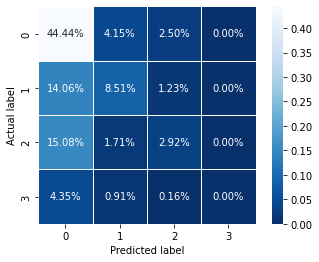

In [91]:
LR_all_importance = LR_all_model.coef_[0]
display(LR_all_importance)
LR_all_confusion_matrix = metrics.confusion_matrix(y_test_all, LR_all_predictions)
sns.heatmap(LR_all_confusion_matrix/np.sum(LR_all_confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

On best 14 features, all the data

In [76]:
LR_allbest_model = LogisticRegression(max_iter = int(1e6))
LR_allbest_model.fit(x_train_bestall, y_train_bestall)
LR_allbest_predictions = LR_allbest_model.predict(x_test_bestall)
LR_allbest_model.score(x_test_bestall, y_test_bestall)

0.5353485735877574

array([ 1.81465111e-08,  1.03970143e-07, -6.68030375e-08,  8.37352408e-09,
        7.79485224e-08,  1.60432285e-08,  4.90051740e-08,  7.41189194e-08,
        3.95497427e-08,  9.84876807e-09,  3.46065305e-08,  2.38457276e-08,
        2.38291862e-08,  1.05472239e-08, -1.67055154e-10, -5.17648774e-08,
        4.02096046e-08,  4.14558229e-08, -1.10841218e-10,  1.49661423e-05,
       -5.20061036e-08, -1.94071042e-17,  5.28050119e-12, -6.71933990e-11,
       -2.69433357e-11, -3.83218588e-11,  1.85807066e-10, -2.64865694e-09,
       -9.71606345e-08, -2.97769563e-09,  6.89611346e-08,  9.37832983e-07,
       -2.28152980e-07, -2.61579623e-06, -3.69915510e-06, -4.62871252e-06,
       -4.41417224e-06])

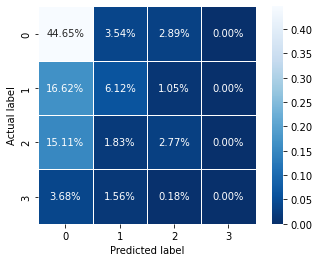

In [82]:
LR_allbest_importance = LR_allbest_model.coef_[0]
display(LR_allbest_importance)
LR_allbest_confusion_matrix = metrics.confusion_matrix(y_test_bestall, LR_allbest_predictions)
sns.heatmap(LR_allbest_confusion_matrix/np.sum(LR_allbest_confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

On best 14 features, subset of the data (balanced dataset)

In [88]:
LR_fbest_model = LogisticRegression(max_iter = int(1e6))
LR_fbest_model.fit(x_train_bestfilter, y_train_bestfilter)
LR_fbest_predictions = LR_fbest_model.predict(x_test_bestfilter)
LR_fbest_model.score(x_test_bestfilter, y_test_bestfilter)

0.5401549841493484

array([-3.92588334e-03,  1.07165660e-05, -9.89270354e-04, -9.24140468e-05,
       -4.70748697e-03, -3.89975643e-03,  7.21823577e-04,  1.76778740e-06,
        3.15693029e-03, -3.16538064e-03, -2.90687795e-03,  4.40861835e-04,
        1.19108464e-02, -6.65649328e-03])

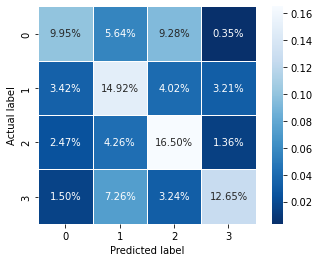

In [89]:
LR_fbest_importance = LR_fbest_model.coef_[0]
display(LR_fbest_importance)
LR_fbest_confusion_matrix = metrics.confusion_matrix(y_test_bestfilter, LR_fbest_predictions)
sns.heatmap(LR_fbest_confusion_matrix/np.sum(LR_fbest_confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Class imbalance at datalevel. Using top 14 best performing features. 

In [44]:
EF_all_best_features = ["shortest_distance_to_track", "dis2coast", "slope", "aspect", "elevation", "clay_content", "sand_content", "soil_density", "silt_content", "storm_surge", "r_sw_34", "min_p", "r_nw_34", "max_sust_wind"]

In [45]:
bestperforming_pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path]
bperf_EF_df = read_and_merge_pkls(bestperforming_pkl_paths)
bperf_EF_df_no_dups = rename_and_drop_duplicated_cols(bperf_EF_df)
# drop r_max_wind as it is a column full of NaNs
bperf_EF_df_no_dups = bperf_EF_df_no_dups.drop(columns=["r_max_wind"])

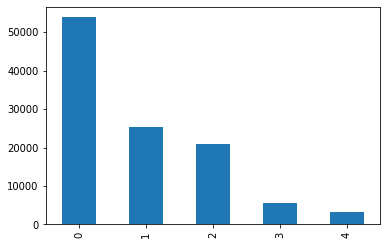

In [46]:
# take 5678 from each class, looking from destroyed (ignore unclassified for now)
DMG_dict = {'no-damage': 0,
 'minor-damage': 1,
 'major-damage': 2,
 'destroyed': 3,
 'un-classified': 4}

value_counts = bperf_EF_df_no_dups.damage_class.value_counts().rename_axis('damage_class').reset_index(name='value_count')
ax = value_counts["value_count"].plot(kind='bar')

In [47]:
DMG_CLASSES_DICT = {'no-damage': 0,
                    'minor-damage': 1,
                    'major-damage': 2,
                    'destroyed': 3,
                    'un-classified': 4}
map_dictionary = {v : k for k, v in DMG_CLASSES_DICT.items()}
bperf_EF_df_no_dups["damage_categorical"] = bperf_EF_df_no_dups["damage_class"].replace(map_dictionary)

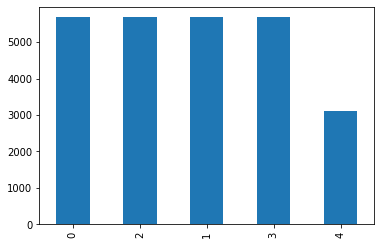

In [48]:
n_sampled_dfs = []
for damage_type in bperf_EF_df_no_dups.damage_class.unique():
  filtered_damage_df = bperf_EF_df_no_dups[bperf_EF_df_no_dups["damage_class"] == (damage_type)]
  value_counts = bperf_EF_df_no_dups.damage_class.value_counts().rename_axis('damage_class').reset_index(name='value_count')
  # damage class 3 is destroyed
  class3_value_count = int(value_counts[(value_counts['damage_class'] == 3)]["value_count"])
  if len(filtered_damage_df) >= class3_value_count:
    random_n_df = filtered_damage_df.sample(n = class3_value_count)
  else: random_n_df = filtered_damage_df
  n_sampled_dfs.append(random_n_df)

balanced_df = pd.concat(n_sampled_dfs)
balanced_value_counts = balanced_df.damage_class.value_counts()
balanced_ax = balanced_value_counts.plot(kind='bar')

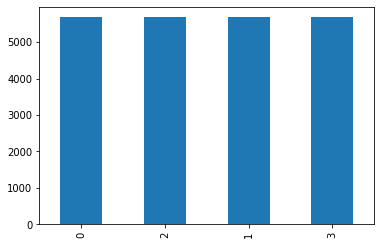

In [49]:
# drop unclassified
balanced_df = balanced_df[balanced_df.damage_class != 4]
balanced_value_counts = balanced_df.damage_class.value_counts()
balanced_ax = balanced_value_counts.plot(kind='bar')

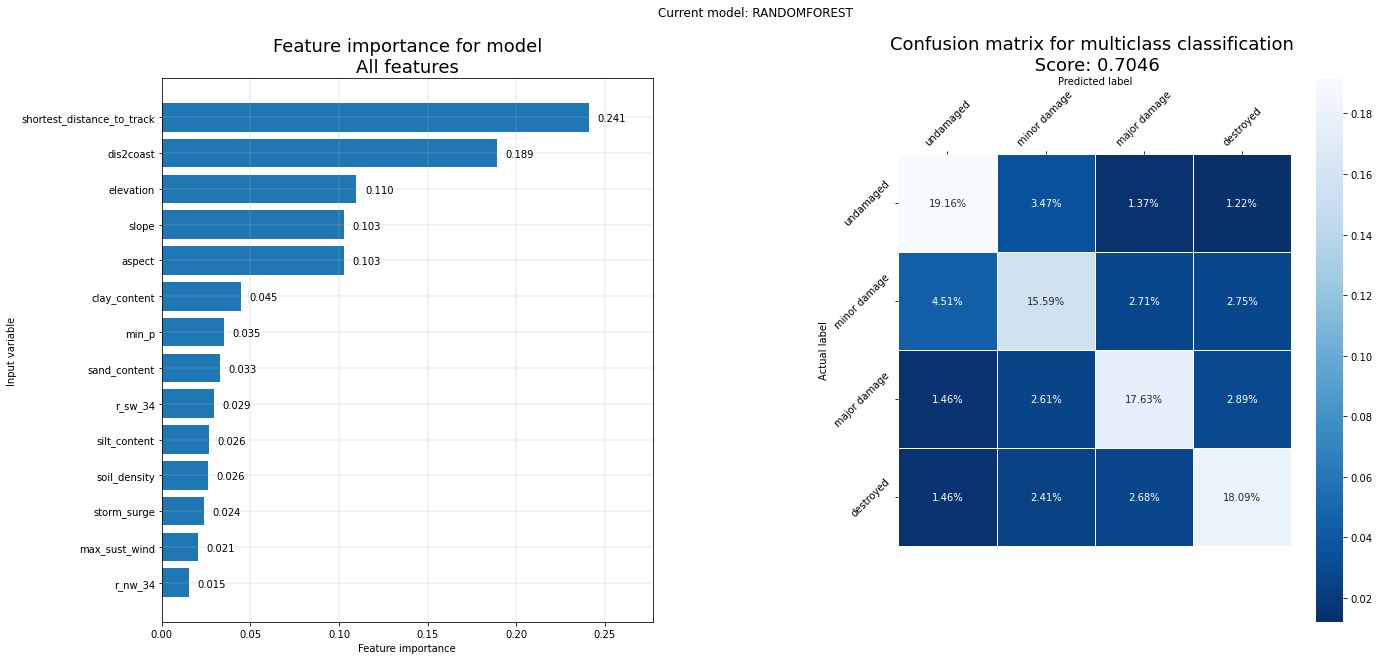

f1 score per class: [0.7396329  0.62810504 0.71988493 0.72966252]
f1 score macro: 0.7043213493754124
weighted f1 score: 0.7054786959975058
precision score: [0.75977654 0.60992419 0.71704871 0.73409578]
recall score: [0.7205298  0.64740307 0.72274368 0.72528249]
balanced accuracy: 0.7039897604830099
accuracy_score: 0.7046495244804508


In [50]:
balanced_df_model_ready = assign_predictor(balanced_df, 'damage_class', drop_classes=[4], binary_classification=False)
all_model_balanced, all_predictions_balanced, all_x_train_balanced, all_x_test_balanced, all_y_train_balanced, all_y_test_balanced, all_score_balanced, all_y_score_balanced, all_importances_balanced = train_test_display_model(
    balanced_df_model_ready, EF_all_best_features, model_name='RandomForest')

## Spatial distribution in test and train dataset
i.e. train on two US hurricanes, test on one US and one Haiti.

In [51]:
def generate_test_train_from_event_subset(
    df: pd.DataFrame,
    var_col_names: list[str],
    y_col: str,
    train_event_names: list[str],
    test_event_names: list[str],
    test_size: float = 0.25,
    random_state: int = 1
):
    """train_event_names and test_event_names should not overlap"""
    # limit training df to specified events 
    df_train_lim = df[df['disaster_name'].isin(train_event_names)]
    df_test_lim = df[df['disaster_name'].isin(test_event_names)]

    x_train, _, y_train, _ = train_test_split(
        df_train_lim[var_col_names],
        df_train_lim[y_col],
        test_size=test_size,
        random_state=random_state)
  
    _, x_test, _, y_test = train_test_split(
        df_test_lim[var_col_names],
        df_test_lim[y_col],
        test_size=test_size,
        random_state=random_state)
    
    # remove hungover index names
    y_train.index.name = None
    y_test.index.name = None

    return x_train, y_train, x_test, y_test


def run_model_from_splits(
    x_train, x_test,
    y_train, y_test,
    model_name,
    var_col_names
):

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_ 

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance


def train_test_display_model(
    df: pd.DataFrame,
    var_col_names: List[str],
    model_name: str = 'LogisticRegression',
    y_col: str = 'y',
    test_size: float = 0.25,
    random_state: int = 1
) -> list:
    """Specify columns in a df to use to train and test model. Currently available models: 'LogisticRegression', 
    'RandomForest'
    """

    x_train, x_test, y_train, y_test = train_test_split(
        df[var_col_names],
        df[y_col],
        test_size=test_size,random_state=random_state)

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_  

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance

In [52]:
filtered_df = pd.read_pickle('/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/filtered_lnglat_pre_pol_post_damage.pkl')
best_features_filtered_df = filtered_df[EF_all_best_features + ['disaster_name', 'damage_class']]
best_features_filtered_df = assign_predictor(best_features_filtered_df, 'damage_class', drop_classes=[4], binary_classification=False)
best_features_filtered_df.head()

<ipython-input-4-1d3870a091d4>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"] = df[col_name].astype(int)


,shortest_distance_to_track,dis2coast,slope,aspect,elevation,clay_content,sand_content,soil_density,silt_content,storm_surge,r_sw_34,min_p,r_nw_34,max_sust_wind,disaster_name,damage_class,y
xbd_index,,,,,,,,,,,,,,,,,
106181,22.2315,544.846928,0.951972,156.801407,13,-32768,-32768,-32768,-32768,4,80.0,919.0,100.0,140,MICHAEL,0,0
108825,31.271708,1404.657747,1.581139,18.434948,12,21,946,121,33,9,80.0,919.0,100.0,140,MICHAEL,0,0
107355,24.114182,1304.633238,0.790569,341.565063,8,-32768,-32768,-32768,-32768,7,80.0,920.0,100.0,135,MICHAEL,0,0
37776,162.232242,62117.140611,2.926175,250.016891,36,-32768,-32768,-32768,-32768,255,0.0,997.0,30.0,40,HARVEY,0,0
94560,149.838526,55360.134966,1.38067,84.805573,36,-32768,-32768,-32768,-32768,255,0.0,997.0,30.0,40,HARVEY,0,0


In [53]:
best_features_filtered_df[best_features_filtered_df.disaster_name == 'MICHAEL']

,shortest_distance_to_track,dis2coast,slope,aspect,elevation,clay_content,sand_content,soil_density,silt_content,storm_surge,r_sw_34,min_p,r_nw_34,max_sust_wind,disaster_name,damage_class,y
xbd_index,,,,,,,,,,,,,,,,,
106181,22.2315,544.846928,0.951972,156.801407,13,-32768,-32768,-32768,-32768,4,80.0,919.0,100.0,140,MICHAEL,0,0
108825,31.271708,1404.657747,1.581139,18.434948,12,21,946,121,33,9,80.0,919.0,100.0,140,MICHAEL,0,0
107355,24.114182,1304.633238,0.790569,341.565063,8,-32768,-32768,-32768,-32768,7,80.0,920.0,100.0,135,MICHAEL,0,0
81263,20.804598,1029.609097,3.005204,196.927505,7,-32768,-32768,-32768,-32768,255,80.0,920.0,100.0,135,MICHAEL,0,0
108867,30.968271,1222.826029,4.031129,150.255112,4,21,946,121,33,12,80.0,919.0,100.0,140,MICHAEL,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17861,21.688501,4783.471804,3.051639,145.00798,25,-32768,-32768,-32768,-32768,255,80.0,920.0,100.0,135,MICHAEL,3,3
76308,22.16698,3658.639799,2.298097,337.619873,8,40,884,124,76,255,80.0,919.0,100.0,140,MICHAEL,3,3
82001,27.520419,2373.606579,2.795085,243.434952,14,-32768,-32768,-32768,-32768,255,80.0,919.0,100.0,140,MICHAEL,3,3


In [54]:
best_features_filtered_df.damage_class.value_counts()

0    5678
2    5678
1    5678
3    5678
Name: damage_class, dtype: int64

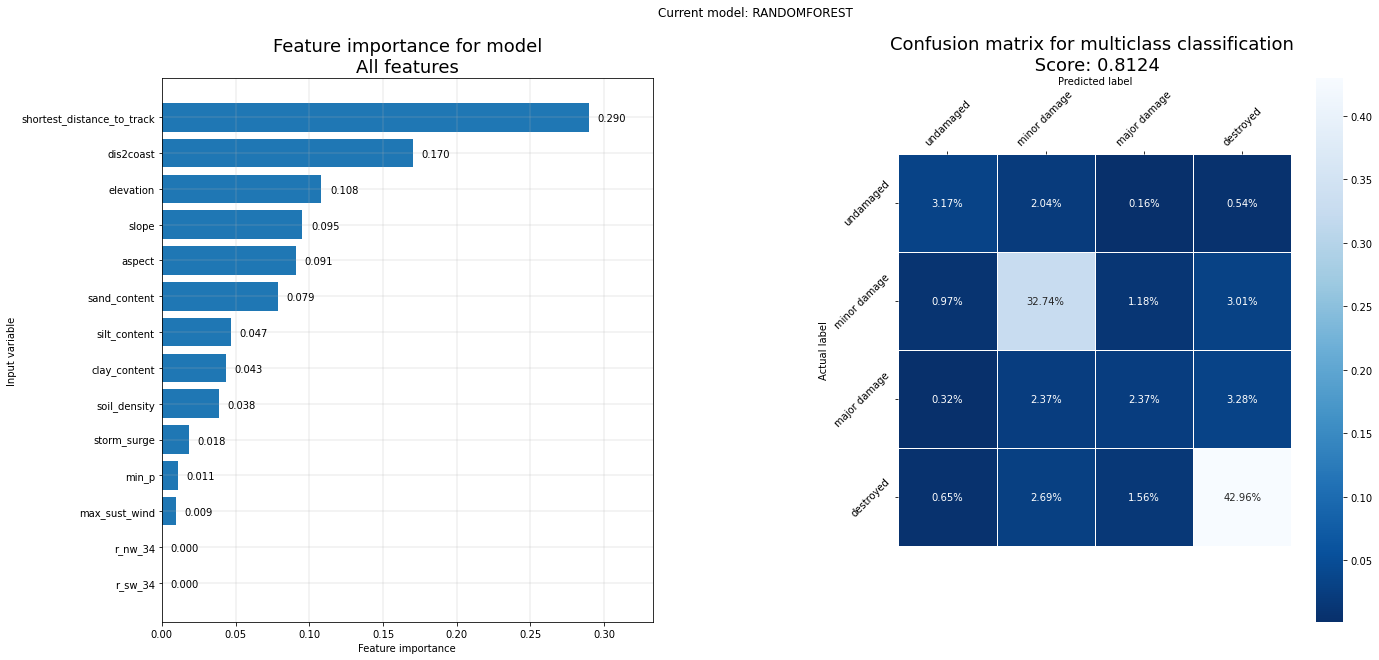

f1 score per class: [0.57560976 0.84232365 0.34782609 0.87995595]
f1 score macro: 0.6614288604107322
weighted f1 score: 0.8213822129707564
precision score: [0.53636364 0.86382979 0.28387097 0.89775281]
recall score: [0.62105263 0.82186235 0.44897959 0.86285097]
balanced accuracy: 0.6886863858790165
accuracy_score: 0.8123655913978495


In [55]:
model_filtered, predictions_filtered, x_train_filtered, x_test_filtered, y_train_filtered, y_test_filtered, score_filtered, y_score_filtered, importances_filtered = train_test_display_model(
    best_features_filtered_df[best_features_filtered_df.disaster_name.isin(['MATTHEW'])], EF_all_best_features, model_name='RandomForest')

<AxesSubplot:>

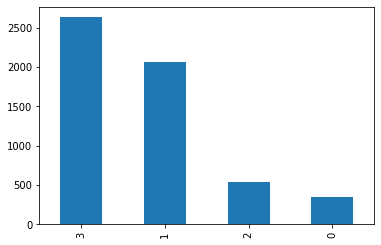

In [56]:
# include plot of x_train and x_test damage levels
y_train_filtered.value_counts().plot.bar()

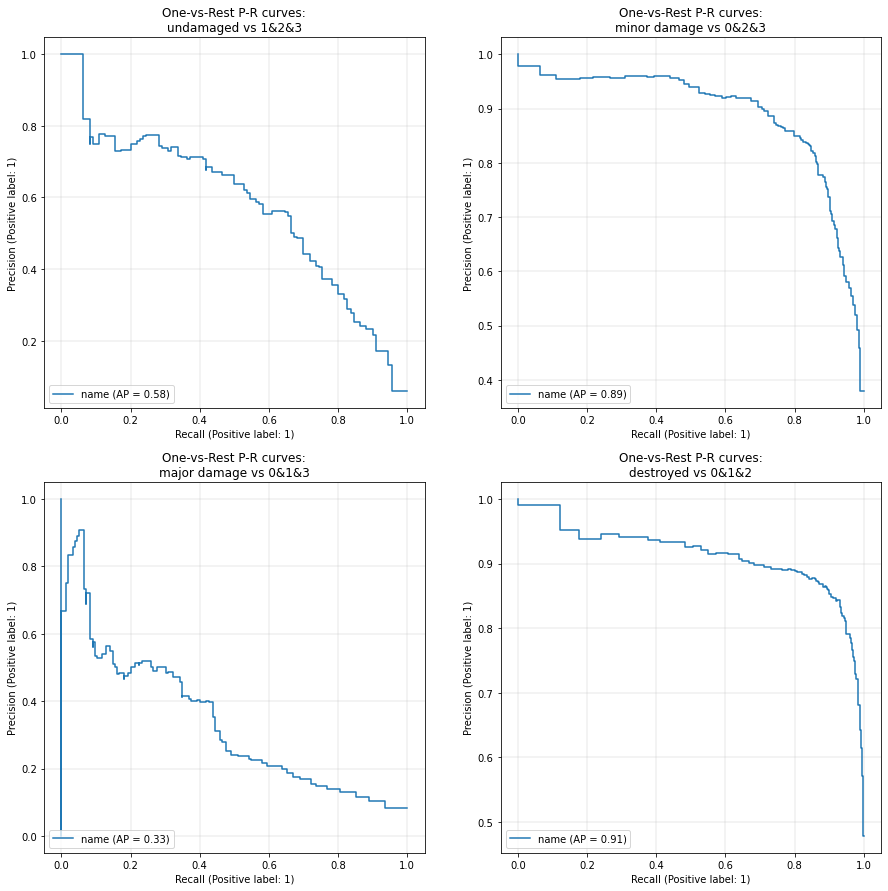

In [57]:
plot_pr_curves(y_test_filtered, y_score_filtered)

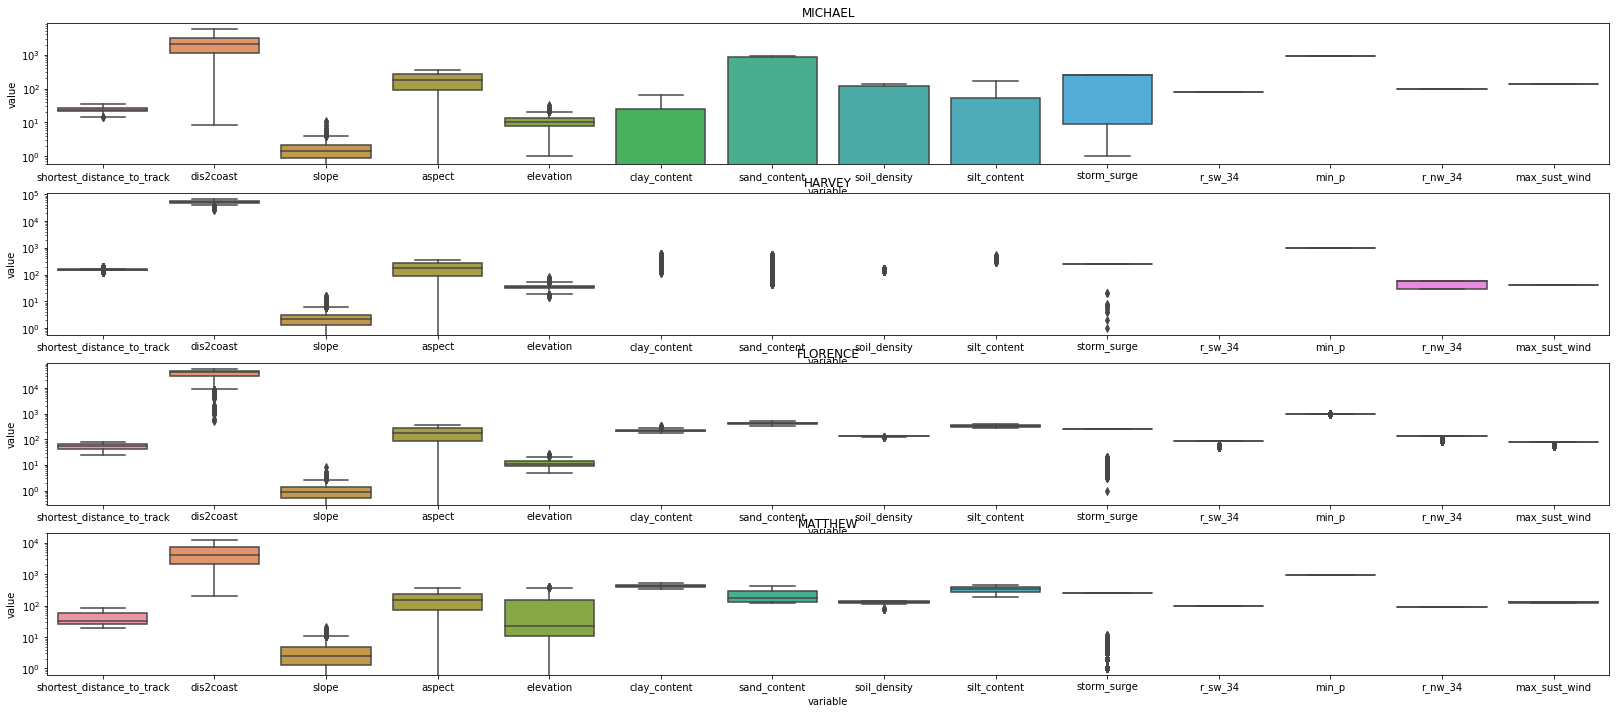

In [58]:
# investigate geographic genericness of EFs
# mean of EFs per event

fig, axes = plt.subplots(4, 1, figsize=[28,12])

for i, name in enumerate(best_features_filtered_df.disaster_name.unique()):
    features = best_features_filtered_df[best_features_filtered_df.disaster_name == name][EF_all_best_features]
    # print(name, features.min(), features.max(), features.mean(), features.var())
    sns.boxplot(ax=axes[i], x="variable", y="value", data=pd.melt(features))
    axes[i].set_title(name)
    axes[i].set_yscale('log')

In [59]:
best_features_filtered_df[EF_all_best_features].columns

Index(['shortest_distance_to_track', 'dis2coast', 'slope', 'aspect',
       'elevation', 'clay_content', 'sand_content', 'soil_density',
       'silt_content', 'storm_surge', 'r_sw_34', 'min_p', 'r_nw_34',
       'max_sust_wind'],
      dtype='object')

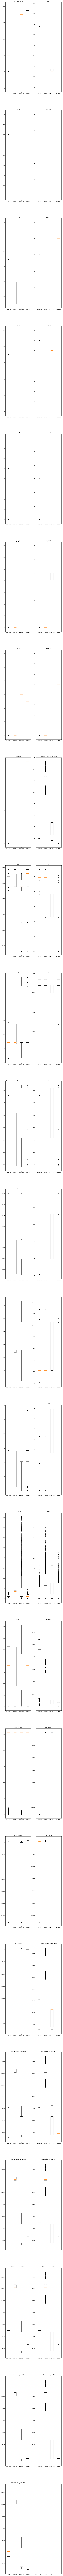

In [60]:
fig, axes = plt.subplots(int(np.ceil(len(all_EF_features)/2)), 2, figsize=[10, 10*len(all_EF_features)])
axes = axes.ravel()
# group data by disaster_name column
grouped = all_df_no_dups.groupby('disaster_name')

# loop through each parameter column and create boxplot
for p, parameter in enumerate(all_EF_features):
    data = [group[1][parameter] for group in grouped]
    axes[p].boxplot(data, labels=grouped.groups.keys())
    axes[p].set_title(parameter)

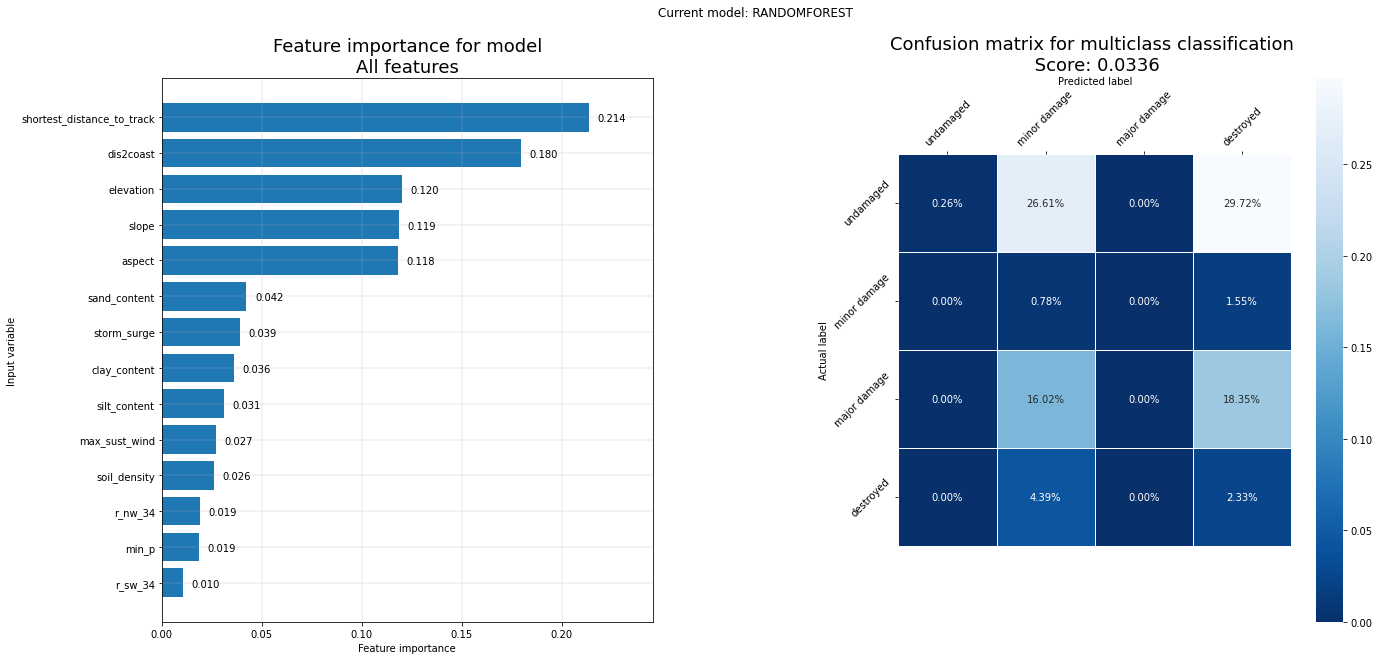

f1 score per class: [0.00909091 0.03092784 0.         0.07929515]
f1 score macro: 0.029828474581869376
weighted f1 score: 0.05599241959900883
precision score: [0.00456621 0.33333333 0.         0.34615385]
recall score: [1.         0.01621622 0.         0.04477612]
balanced accuracy: 0.2652480839048003
accuracy_score: 0.03359173126614987


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
x_train_mi_f_h, y_train_mi_f_h, x_test_mi_f_h, y_test_mi_f_h = generate_test_train_from_event_subset(
    best_features_filtered_df,
    var_col_names = EF_all_best_features,
    y_col = 'y',
    train_event_names = ['MICHAEL', 'MICHAEL', 'MATTHEW'],
    test_event_names = ['FLORENCE'],
)

all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train_mi_f_h, x_test_mi_f_h, y_train_mi_f_h, y_test_mi_f_h, 'RandomForest', EF_all_best_features)

In [62]:
best_features_df = all_df_no_dups[EF_all_best_features + ['disaster_name', 'damage_class']]
best_features_df.head()

best_features_df = assign_predictor(best_features_df, 'damage_class', drop_classes=[4], binary_classification=False)

all_features_df = all_df_no_dups[all_EF_features + ['disaster_name', 'damage_class']]
all_features_df = assign_predictor(all_features_df, 'damage_class', drop_classes=[4], binary_classification=False)

<ipython-input-4-1d3870a091d4>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"] = df[col_name].astype(int)
<ipython-input-4-1d3870a091d4>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"] = df[col_name].astype(int)


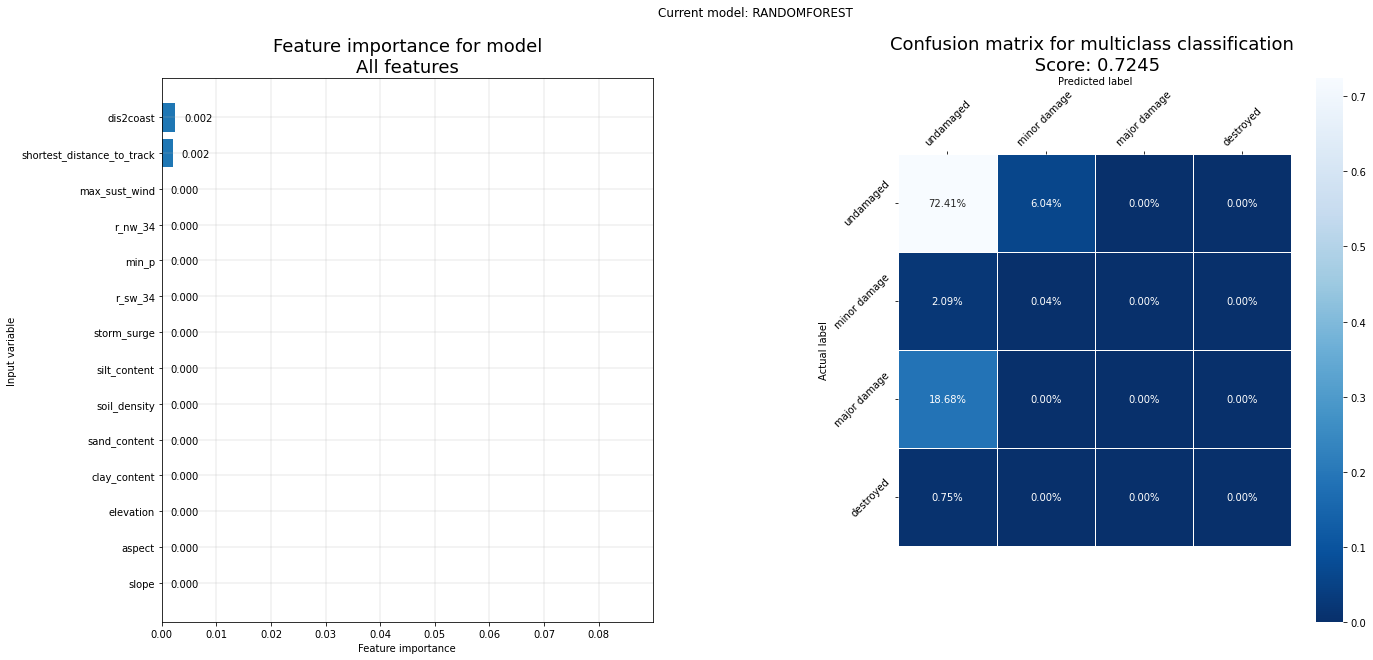

f1 score per class: [0.84014709 0.00909091 0.         0.        ]
f1 score macro: 0.21230949993117415
weighted f1 score: 0.7896392018972145
precision score: [0.9230038  0.01754386 0.         0.        ]
recall score: [0.77094085 0.00613497 0.         0.        ]
balanced accuracy: 0.19426895471715575
accuracy_score: 0.7244593586875466


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
x_train_mi_f, y_train_mi_f, x_test_mi_f, y_test_mi_f = generate_test_train_from_event_subset(
    all_features_df,
    var_col_names = all_EF_features,
    y_col = 'y',
    train_event_names = ['MICHAEL'],
    test_event_names = ['FLORENCE'],
)

all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train_mi_f, x_test_mi_f, y_train_mi_f, y_test_mi_f, 'RandomForest', EF_all_best_features)

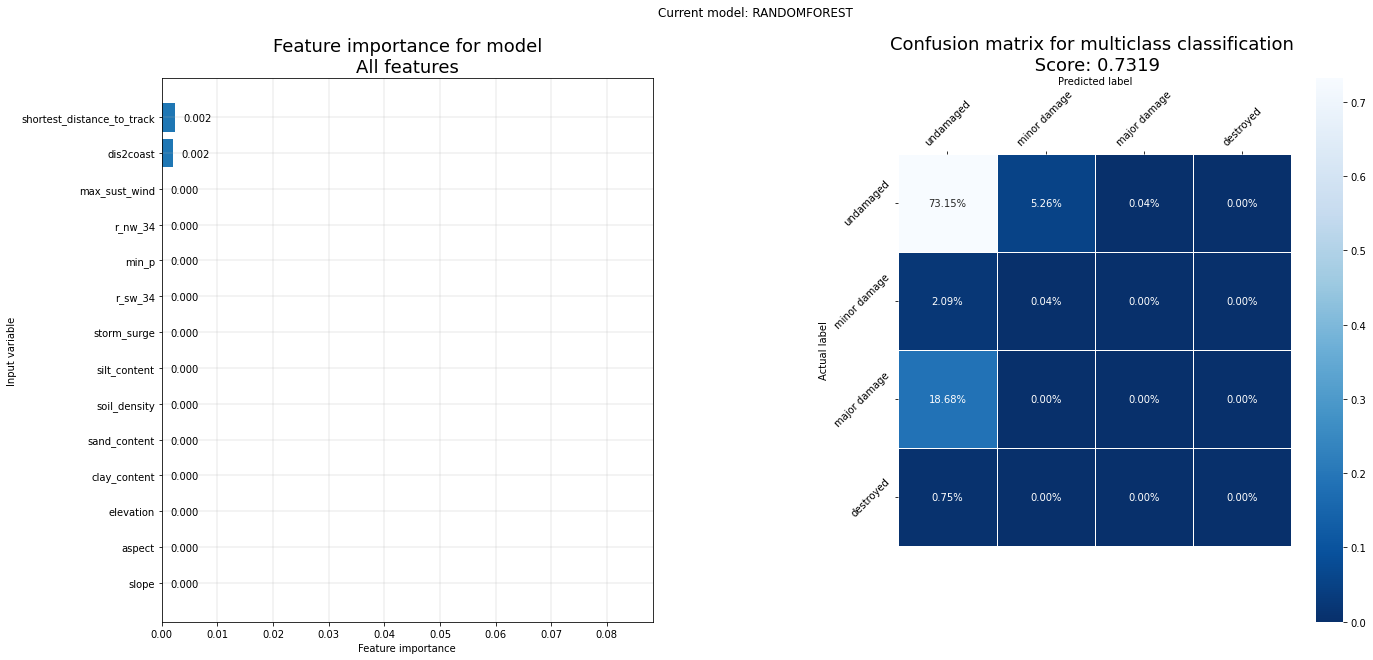

f1 score per class: [0.84514323 0.01005025 0.         0.        ]
f1 score macro: 0.21379836940463684
weighted f1 score: 0.8006136418389952
precision score: [0.93250951 0.01754386 0.         0.        ]
recall score: [0.77274518 0.00704225 0.         0.        ]
balanced accuracy: 0.19494685719674487
accuracy_score: 0.7319164802386279


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
x_train_mi_f, y_train_mi_f, x_test_mi_f, y_test_mi_f = generate_test_train_from_event_subset(
    all_features_df,
    var_col_names = all_EF_features,
    y_col = 'y',
    train_event_names = ['MICHAEL'],
    test_event_names = ['FLORENCE'],
)

all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train_mi_f, x_test_mi_f, y_train_mi_f, y_test_mi_f, 'RandomForest', EF_all_best_features)

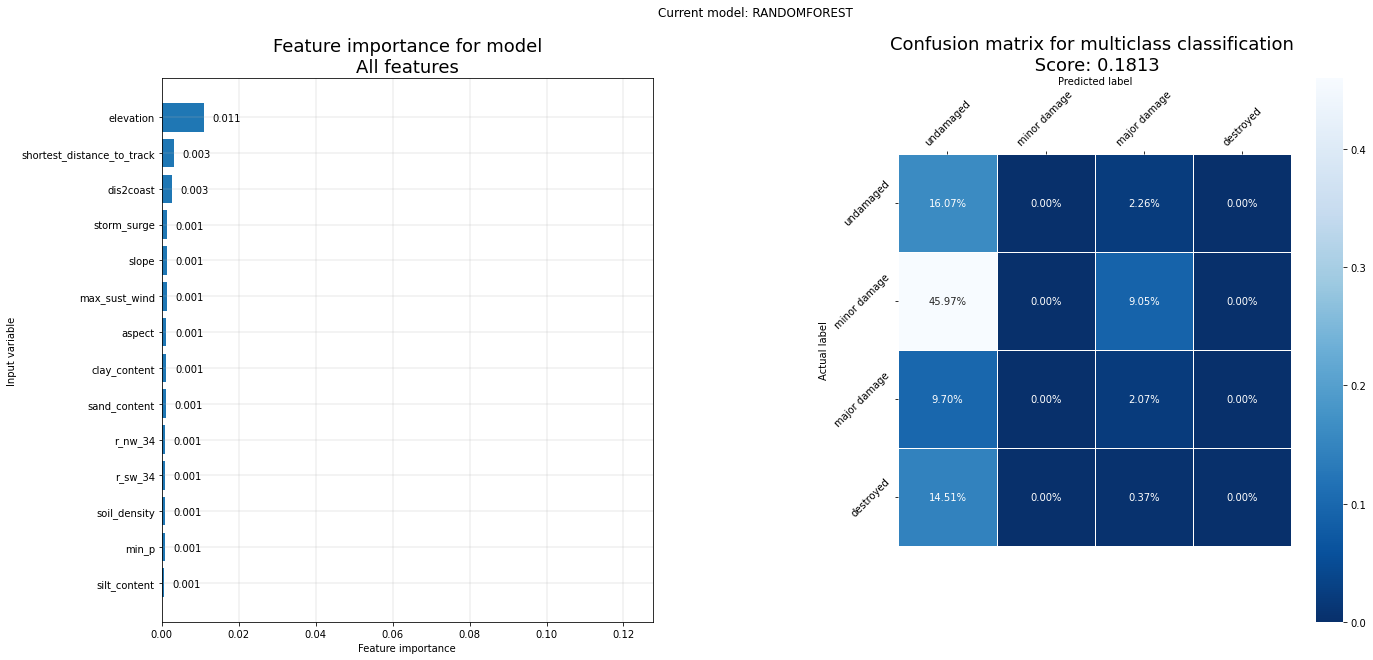

f1 score per class: [0.3072503  0.         0.16204986 0.        ]
f1 score macro: 0.11732503931345759
weighted f1 score: 0.2872845944755632
precision score: [0.87656702 0.         0.17567568 0.        ]
recall score: [0.18627049 0.         0.1503856  0.        ]
balanced accuracy: 0.08416402397909731
accuracy_score: 0.18133616118769882


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
x_train_mi_f_h, y_train_mi_f_h, x_test_mi_f_h, y_test_mi_f_h = generate_test_train_from_event_subset(
    all_features_df,
    var_col_names = all_EF_features,
    y_col = 'y',
    train_event_names = ['MICHAEL', 'FLORENCE', 'HARVEY'],
    test_event_names = ['MATTHEW'],
)

all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train_mi_f_h, x_test_mi_f_h, y_train_mi_f_h, y_test_mi_f_h, 'RandomForest', EF_all_best_features)

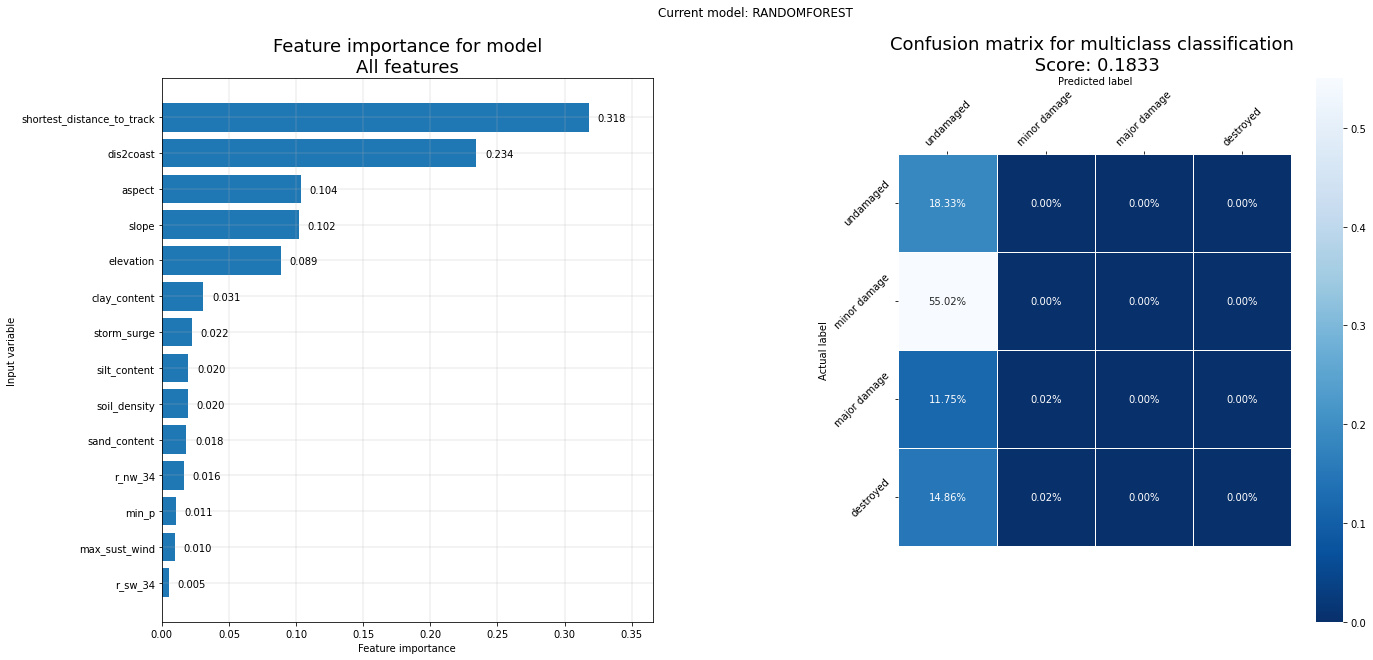

f1 score per class: [0.30987599 0.         0.         0.        ]
f1 score macro: 0.07746899746003287
weighted f1 score: 0.30976645431880234
precision score: [1. 0. 0. 0.]
recall score: [0.18334512 0.         0.         0.        ]
balanced accuracy: 0.04583628005657708
accuracy_score: 0.1832803110639802


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
x_train, y_train, x_test, y_test = generate_test_train_from_event_subset(
    best_features_df,
    var_col_names = EF_all_best_features,
    y_col = 'y',
    train_event_names = ['MICHAEL', 'FLORENCE', 'HARVEY'],
    test_event_names = ['MATTHEW'],
)
all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train, x_test, y_train, y_test, 'RandomForest', EF_all_best_features)

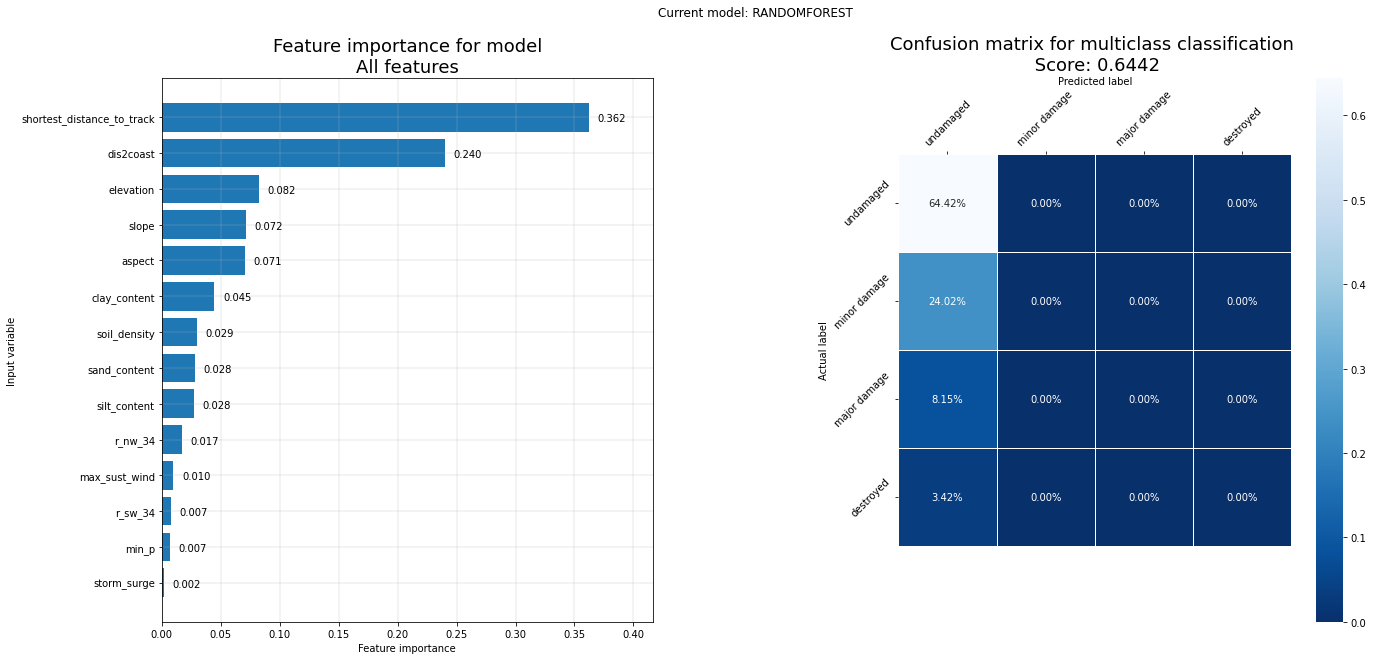

f1 score per class: [0.78357227 0.         0.         0.        ]
f1 score macro: 0.19589306738693818
weighted f1 score: 0.7835722695477527
precision score: [1. 0. 0. 0.]
recall score: [0.64415851 0.         0.         0.        ]
balanced accuracy: 0.16103962650876794
accuracy_score: 0.6441585060350717


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
x_train, y_train, x_test, y_test = generate_test_train_from_event_subset(
    best_features_df,
    var_col_names = EF_all_best_features,
    y_col = 'y',
    train_event_names = ['FLORENCE', 'HARVEY'],
    test_event_names = ['MICHAEL'],
)
all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train, x_test, y_train, y_test, 'RandomForest', EF_all_best_features)

# Random forest hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(rf_random.best_params_)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

In [ ]:
# this section is Work In Progress. 

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = model.score(x_train, y_train)

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

In [ ]:
best["criterion"] = "entropy"

In [ ]:
model = RandomForestClassifier(**best)
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)
model.score(x_test, y_test)

In [ ]:
importance = best.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Random Forest Model

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# XGBoost Model

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# This space is JUST for rlazando
